# EDA - Exploratory Data Analysis.
A Análise Exploratória de Dados a seguir tem como objetivo responder alguns questionamentos relacionados às vendas feitas por uma organização de comércio varejista bengali. Os dados que alimentam a análise foram coletados entre os anos de 2014 e 2021 (2021 apenas o mês de janeiro) e os valores monetários estão na moeda local, o Taka Bengali (Tk).

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.stats import pearsonr  # Para calcular correlação de Pearson

In [2]:
# Conecta ao banco de dados.
con = sqlite3.connect("projetoecommerce.db")

In [3]:
# Armazena o cursor.
cur = con.cursor()

In [4]:
# Executa a consulta SQL e carrega no DataFrame dfecommerce.
dfecommerce = pd.read_sql_query("""
    SELECT *
    FROM fact_table
    LEFT JOIN customer_dim ON customer_dim.customer_key = fact_table.coustomer_key
    LEFT JOIN item_dim ON item_dim.item_key = fact_table.item_key
    LEFT JOIN store_dim_com_population ON store_dim_com_population.store_key = fact_table.store_key
    LEFT JOIN time_dim ON time_dim.time_key = fact_table.time_key
    LEFT JOIN Trans_dim ON Trans_dim.payment_key = fact_table.payment_key
""", con)

In [5]:
pd.set_option('display.max_columns', None) # Estabelece que todas as colunas do DataFrame apareçam.

In [6]:
dfecommerce.head()

,payment_key,coustomer_key,time_key,item_key,store_key,quantity,unit,unit_price,total_price,customer_key,name,contact_no,nid,item_key,item_name,desc,unit_price,man_country,supplier,unit,store_key,division,district,upazila,population,time_key,date,hour,day,week,month,quarter,year,payment_key,trans_type,bank_name
0,P026,C004510,T049189,I00177,S00307,1,ct,35.0,35.0,C004510,priya,8801529462805,4543429591184,I00177,M&M Peanut Candy 1.7 oz,Food - Chocolate,35.0,Netherlands,Bolsius Boxmeer,ct,S00307,DHAKA,JAMALPUR,ISLAMPUR,10200000,T049189,26-04-2016 17:13,17,26,4th Week,4,Q2,2016,P026,card,Premier Bank Limited
1,P022,C008967,T041209,I00248,S00595,1,rolls,26.0,26.0,C008967,harpreet kaur,8801985295010,9673146002795,I00248,Charmin Ultra Bath Tissue,Kitchen Supplies,26.0,Bangladesh,DENIMACH LTD,rolls,S00595,DHAKA,DHAKA,CANTONMENT,10200000,T041209,11-06-2018 19:08,19,11,2nd Week,6,Q2,2018,P022,card,NRB Commercial Bank Ltd
2,P030,C007261,T03633,I00195,S00496,8,ct,12.5,100.0,C007261,sonam,8801955748165,2335742897063,I00195,Dole Fruit in Gel Cups 4.3 oz,Food - Healthy,12.5,poland,CHROMADURLIN S.A.S,ct,S00496,CHITTAGONG,NOAKHALI,BEGUMGANJ,5500000,T03633,19-11-2016 08:19,8,19,3rd Week,11,Q4,2016,P030,card,Shimanto Bank Ltd
3,P032,C007048,T084631,I00131,S0086,8,ct,14.0,112.0,C007048,rekha bai,8801927509185,4943555261118,I00131,Paper Bowls 20 oz Ultra Strong,Dishware - Bowls,14.0,Bangladesh,DENIMACH LTD,ct,S0086,RANGPUR,RANGPUR,KAUNIA,343100,T084631,01-02-2020 06:00,6,1,1st Week,2,Q1,2020,P032,card,South Bangla Agriculture and Commerce Bank Lim...
4,P014,C006430,T071276,I00050,S00488,8,cans,8.0,64.0,C006430,mamta devi,8801549045065,3602133066555,I00050,Waterloo Sparkling Watermelon 12oz,a. Beverage Sparkling Water,8.0,poland,CHROMADURLIN S.A.S,cans,S00488,CHITTAGONG,KHAGRACHHARI,MATIRANGA,5500000,T071276,15-07-2014 02:58,2,15,3rd Week,7,Q3,2014,P014,card,Meghna Bank Limited


In [7]:
dfecommerce.info() # Traz o formato dos dados.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 36 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   payment_key    1000000 non-null  object 
 1   coustomer_key  1000000 non-null  object 
 2   time_key       1000000 non-null  object 
 3   item_key       1000000 non-null  object 
 4   store_key      1000000 non-null  object 
 5   quantity       1000000 non-null  int64  
 6   unit           996277 non-null   object 
 7   unit_price     1000000 non-null  float64
 8   total_price    1000000 non-null  float64
 9   customer_key   1000000 non-null  object 
 10  name           997010 non-null   object 
 11  contact_no     1000000 non-null  object 
 12  nid            1000000 non-null  object 
 13  item_key       1000000 non-null  object 
 14  item_name      1000000 non-null  object 
 15  desc           1000000 non-null  object 
 16  unit_price     1000000 non-null  float64
 17  man_count

In [8]:
# Converte as colunas 'date', 'hour', 'day', 'month' e 'year' de int64 para object. Isso é feito para evitar que essas colunas sejam consideradas nas estatísticas como 
# valores numéricos.
dfecommerce[['date', 'hour', 'day', 'month', 'year']] = dfecommerce[['date', 'hour', 'day', 'month', 'year']].astype(object)

In [9]:
# Remove colunas duplicadas (item_key).
dfecommerce = dfecommerce.loc[:, ~dfecommerce.columns.duplicated()]

In [10]:
dfecommerce.to_sql("dfecommerce", con, if_exists="replace", index=False) # Converte o DataFrame dfecommerce em uma tabela de mesmo nome do DataBase 
# projetoecommerce.

1000000

In [11]:
dfecommerce.describe() # Gera informações estatísticas das variáveis numéricas.

,quantity,unit_price,total_price,population
count,1000000.000000,1000000.000000,1000000.000000,1.000000e+06
mean,6.000185,17.561602,105.401436,5.197997e+06
std,3.161932,8.637097,80.829301,4.364642e+06
min,1.000000,6.000000,6.000000,2.022000e+05
25%,3.000000,13.000000,47.250000,5.533000e+05
50%,6.000000,16.000000,90.000000,5.500000e+06
75%,9.000000,20.000000,144.000000,1.020000e+07
max,11.000000,55.000000,605.000000,1.020000e+07


## Quem são os fornecedores dos 10 produtos mais caros?

In [12]:
df_top10_caros = pd.read_sql_query("""
    SELECT item_name AS Produto, unit_price AS Preco_Unitario
    FROM item_dim
    ORDER BY Preco_Unitario DESC
    LIMIT 10
""", con) # Define a consulta dos 5 produtos mais caros e salva em dataframe pandas.

df_top10_caros.head()

,Produto,Preco_Unitario
0,Red Bull 12oz,55.0
1,K Cups Daily Chef Columbian Supremo,53.0
2,K Cups Original Donut Shop Med. Roast,53.0
3,K Cups Dunkin Donuts Medium Roast,48.0
4,K Cups Folgers Lively Columbian,46.0


In [13]:
top5_supplier_caros = dfecommerce[dfecommerce['item_name'].isin(df_top10_caros['Produto'])]['supplier'].unique() # Traz de dfecommerce os valores da coluna 
                                                                                                                # supplier onde os valores de item_name são 
                                                                                                                # iguais aos de item_name em df_top5_caros.
        
top5_supplier_caros # Apresenta o array resultante.

array(['Indo Count Industries Ltd', 'Bolsius Boxmeer', 'MAESA SAS',
       'BIGSO AB', 'CHROMADURLIN S.A.S', 'NINGBO SEDUNO IMP & EXP CO.LTD',
       'HARDFORD AB'], dtype=object)

Construir e visualizar o panorama logístico e comercial de uma organização inclui acessar alguns detalhes que englobam, por exemplo, conhecer quais são os fornecedores dos produtos com maior valor e os mais vendidos. Informações como estas, acrescidas de outras de igual importância, permitem definir o retrato dos fornecedores e qual sua distribuição em relação aos produtos vendidos. No contexto estratégico e de resolução de questões, esse conhecimento pode apoiar a definição da troca de fornecedores, renegociação de valores, entre outras medidas.

## Quem são os fornecedores dos 10 produtos mais vendidos?

In [14]:
df_top10_vendidos = pd.read_sql_query("""
    SELECT item_name AS Produto, SUM(quantity) AS Quantidade_Total_Vendida
    FROM dfecommerce
    GROUP BY Produto
    ORDER BY Quantidade_Total_Vendida DESC
    LIMIT 10
""", con) # Define a consulta dos 5 produtos mais vendidos e salva em dataframe pandas.

df_top10_vendidos.head(10)

,Produto,Quantidade_Total_Vendida
0,Pepsi - 12 oz cans,46837
1,Muscle Milk Protein Shake Van. 11oz,45665
2,Coke Classic 12 oz cans,45501
3,Diet Coke - 12 oz cans,45202
4,Sprite - 12 oz cans,45140
5,Diet Pepsi - 12 oz cans,23969
6,Nat.Valley PeanutButter Protein Bars,23958
7,"Nabisco Classic Mix ccooki, cracker",23852
8,Red Bull 12oz,23740
9,Cascade Gel Packs Dishwasher,23648


In [15]:
top5_supplier_vendidos = dfecommerce[dfecommerce['item_name'].isin(df_top10_vendidos['Produto'])]['supplier'].unique() # Traz de dfecommerce os valores da 
                                                                                                                      # coluna supplier onde os valores de 
                                                                                                                      # item_name são iguais aos de item_name 
                                                                                                                      # em df_top5_vendidos.

top5_supplier_vendidos # Apresenta o array resultante.

array(['NINGBO SEDUNO IMP & EXP CO.LTD', 'Friedola 1888 GmbH',
       'Indo Count Industries Ltd', 'BIGSO AB', 'Bolsius Boxmeer',
       'MAESA SAS', 'CHROMADURLIN S.A.S'], dtype=object)

## Quais são os 10 itens que mais faturaram?

In [16]:
df_top10_faturado = pd.read_sql_query("""
    SELECT item_name AS Produto, SUM(total_price) AS Faturamento_Total
    FROM dfecommerce
    GROUP BY Produto
    ORDER BY Faturamento_Total DESC
    LIMIT 10
""", con)

df_top10_faturado.head(10) 

,Produto,Faturamento_Total
0,Red Bull 12oz,1305700.0
1,K Cups Daily Chef Columbian Supremo,1245394.0
2,K Cups Original Donut Shop Med. Roast,1188843.0
3,K Cups Dunkin Donuts Medium Roast,1109760.0
4,Muscle Milk Protein Shake Van. 11oz,1050924.0
5,K Cups Folgers Lively Columbian,1042406.0
6,Honey Packets,1012995.0
7,K Cups  Starbuck's Pike Place,995456.0
8,K Cups Organic Breakfast Blend,957516.0
9,K Cups - McCafe Premium Roast,956886.0


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


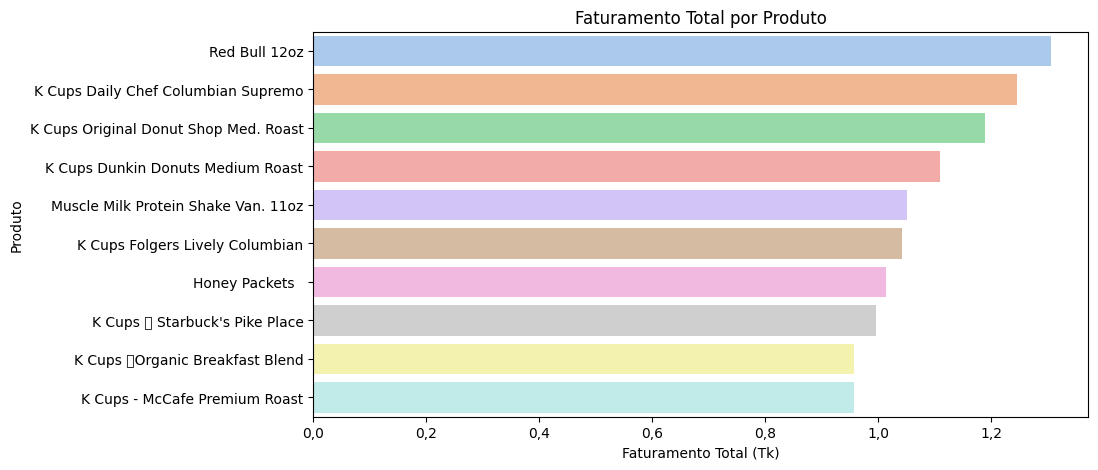

In [17]:
# Cria o gráfico de barras.
plt.figure(figsize=(10, 5))
sns.barplot(data=df_top10_faturado, x=df_top10_faturado["Faturamento_Total"] / 1_000_000, y="Produto", palette="pastel")

# Define títulos.
plt.xlabel("Faturamento Total (Tk)")
plt.ylabel("Produto")
plt.title("Faturamento Total por Produto")

# Ajusta o formato do eixo X para exibir os valores no formato brasileiro.
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.1f}".replace(",", "X").replace(".", ",").replace("X", ".")))

plt.show()


As informações que este gráfico fornece dizem respeito a quais são os 10 itens com maior participação no faturamento deste comércio varejista. Entre os 10 produtos elencados, pode-se identificar, de cima para baixo, os 3 produtos mais relevantes, seguidos de 2 grupos cujos produtos representam arrecadações muito semelhantes. O primeiro grupo inclui produtos de faturamento mediano e o segundo, os de faturamento mais baixo. Considerando a relevância desse conhecimento, uma vez enriquecido de mais dados, poderão apoiar a elaboração de campanhas direcionadas a um ou mais produtos e compor um diagnóstico que indique o perfil de vendas e consumo, por exemplo.

## Quais países mais forneceram produtos?

In [18]:
df_topcountrypsupplier = pd.read_sql_query("""
    SELECT SUM(total_price) AS Faturamento, man_country AS Pais
    FROM dfecommerce
    GROUP BY Pais
    ORDER BY Faturamento DESC
""", con)

df_topcountrypsupplier.head(10)

,Faturamento,Pais
0,13337300.50,Bangladesh
1,13159323.25,India
2,11746920.00,Lithuania
3,10976287.50,poland
4,10957102.25,Germany
5,10458204.00,Netherlands
6,9892983.50,United States
7,9463861.50,Cambodia
8,9416792.25,Finland
9,5992661.00,China


In [19]:
# Ordenar em ordem decrescente
df_topcountrypsupplier1 = df_topcountrypsupplier.sort_values(by='Faturamento', ascending=False)

# Calcular porcentagem acumulada
df_topcountrypsupplier1['% Acumulada'] = df_topcountrypsupplier1['Faturamento'].cumsum() / df_topcountrypsupplier1['Faturamento'].sum() * 100

df_topcountrypsupplier1.head(10)

,Faturamento,Pais,% Acumulada
0,13337300.50,Bangladesh,12.653813
1,13159323.25,India,25.138769
2,11746920.00,Lithuania,36.283703
3,10976287.50,poland,46.697496
4,10957102.25,Germany,57.093087
5,10458204.00,Netherlands,67.015347
6,9892983.50,United States,76.401351
7,9463861.50,Cambodia,85.380225
8,9416792.25,Finland,94.314441
9,5992661.00,China,100.000000


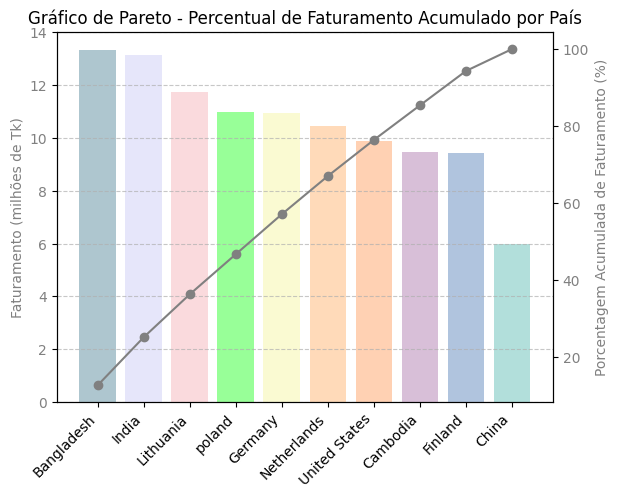

In [20]:
# Cores em tons pastel
cores_pastel = ['#AEC6CF', '#E6E6FA', '#FADADD', '#98FF98', '#FAFAD2', '#FFDAB9', '#FFD1B3', '#D8BFD8', '#B0C4DE', '#B2DFDB']

# Criar a figura e eixo
fig, ax1 = plt.subplots()

# Gráfico de barras (frequências)
ax1.bar(df_topcountrypsupplier1['Pais'], df_topcountrypsupplier1['Faturamento'], color=cores_pastel, label='Faturamento')
ax1.set_ylabel('Faturamento (milhões de Tk)', color='grey')
ax1.tick_params(axis='y', labelcolor='grey')

# Formatar os números do eixo Y dividindo por 1.000.000
def formatar_milhoes(x, pos):
    return f'{x / 1_000_000:.0f}'.replace('.', ',')

ax1.yaxis.set_major_formatter(FuncFormatter(formatar_milhoes))

# Definir rótulos do eixo X corretamente
ax1.set_xticks(range(len(df_topcountrypsupplier1['Pais'])))  
ax1.set_xticklabels(df_topcountrypsupplier1['Pais'], rotation=45, ha='right')

# Criar o segundo eixo Y
ax2 = ax1.twinx()

# Gráfico de linha (% acumulada)
ax2.plot(df_topcountrypsupplier1['Pais'], df_topcountrypsupplier1['% Acumulada'], color='grey', marker='o', linestyle='-', label='% Acumulada')
ax2.set_ylabel('Porcentagem Acumulada de Faturamento (%)', color='grey')
ax2.tick_params(axis='y', labelcolor='grey')

# Adicionar linhas de grade e título
ax1.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Gráfico de Pareto - Percentual de Faturamento Acumulado por País')

# Exibir o gráfico
plt.show()

O gráfico de Pareto acima apresenta a relação entre os países exportadores, o faturamento feito com a venda destes produtos importados e a porcentagem acumulada deste faturamento. Os dados analisados não trazem informações diretas sobre as transações feitas entre a empresa e os fornecedores, apresentando apenas dados do comércio feito com o cliente final. Por esse motivo, foi possível avaliar apenas quais países são mais importantes para o faturamento da organização, mas não qual foi a margem de lucro bruto.

Após definir essa conexão e construir o gráfico apresentado, identifica-se que o somatório do faturamento para os produtos de 7 países (Bangladesh, Índia, Lituânia, Polônia, Alemanha, Países Baixos e Estados Unidos) corresponde a 80% do faturamento total. Isso aponta para a diversificação da origem dos produtos oferecidos pela empresa e que o abastecimento, e consequentemente a arrecadação, não depende de poucas nações para manter-se, o que é bastante positivo.

## Quem são os 10 clientes que mais gastaram?

In [21]:
df_top10clientes = pd.read_sql_query("""
    SELECT SUM(total_price) AS Faturamento_por_Cliente, nid AS Cod_Identificacao
    FROM dfecommerce
    GROUP BY Cod_Identificacao
    ORDER BY Faturamento_por_Cliente DESC
    LIMIT 10
""", con)

df_top10clientes.head()

,Faturamento_por_Cliente,Cod_Identificacao
0,17104.50,3363189579774
1,16853.25,5460077703177
2,16645.75,2926597740546
3,16381.50,1361853474451
4,16288.75,6660906846744


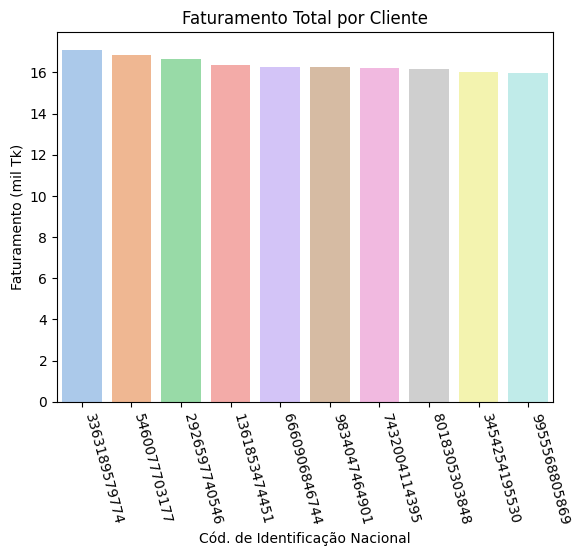

In [22]:
# Cria o gráfico de barras.
sns.barplot(data=df_top10clientes, x="Cod_Identificacao", y="Faturamento_por_Cliente", palette="pastel")

# Rotaciona os rótulos do eixo X.
plt.xticks(rotation=-75, ha="left")

# Define títulos.
plt.xlabel("Cód. de Identificação Nacional")
plt.ylabel("Faturamento (mil Tk)")
plt.title("Faturamento Total por Cliente")

# Formatar os valores do eixo Y dividindo por 1.000
def formatar_milhar(x, _):
    return f"{x / 1_000:.0f}".replace(".", ",")

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(formatar_milhar))

plt.show() 

Este gráfico, por sua vez, traz os 10 clientes que mais se destacaram como consumidores no intervalo de tempo avaliado. Pensando em como definir medidas que fidelizem e, também, na identificação dos públicos consumidores mais representativos, é muito útil considerar informações como esta.

Quanto à análise, pode-se afirmar que não há grande variação entre o faturamento vinculado a cada um dos clientes, com uma diferença que não chega aos Tk 2.000,00 entre o consumidor com o primeiro e o com o décimo faturamento mais expressivo. 

## Como varia o faturamento ao longo do período analisado?

Para responder este questionamento foram elaboradas análises sob três visões: visão mensal e anual de todo o período (2014 - 2020), mensal e anual individual e anual.

In [23]:
# Obtém os valores únicos da coluna "year".
valores_unicos = dfecommerce['year'].unique()

print(valores_unicos)

[2016 2018 2020 2014 2019 2017 2015 2021]


In [24]:
# Cria a coluna "month_year" no formato YYYY-MM.
dfecommerce["month_year"] = dfecommerce["year"].astype(str) + "-" + dfecommerce["month"].astype(str).str.zfill(2)

# Exibe o DataFrame atualizado.
dfecommerce.head()

,payment_key,coustomer_key,time_key,item_key,store_key,quantity,unit,unit_price,total_price,customer_key,name,contact_no,nid,item_name,desc,man_country,supplier,division,district,upazila,population,date,hour,day,week,month,quarter,year,trans_type,bank_name,month_year
0,P026,C004510,T049189,I00177,S00307,1,ct,35.0,35.0,C004510,priya,8801529462805,4543429591184,M&M Peanut Candy 1.7 oz,Food - Chocolate,Netherlands,Bolsius Boxmeer,DHAKA,JAMALPUR,ISLAMPUR,10200000,26-04-2016 17:13,17,26,4th Week,4,Q2,2016,card,Premier Bank Limited,2016-04
1,P022,C008967,T041209,I00248,S00595,1,rolls,26.0,26.0,C008967,harpreet kaur,8801985295010,9673146002795,Charmin Ultra Bath Tissue,Kitchen Supplies,Bangladesh,DENIMACH LTD,DHAKA,DHAKA,CANTONMENT,10200000,11-06-2018 19:08,19,11,2nd Week,6,Q2,2018,card,NRB Commercial Bank Ltd,2018-06
2,P030,C007261,T03633,I00195,S00496,8,ct,12.5,100.0,C007261,sonam,8801955748165,2335742897063,Dole Fruit in Gel Cups 4.3 oz,Food - Healthy,poland,CHROMADURLIN S.A.S,CHITTAGONG,NOAKHALI,BEGUMGANJ,5500000,19-11-2016 08:19,8,19,3rd Week,11,Q4,2016,card,Shimanto Bank Ltd,2016-11
3,P032,C007048,T084631,I00131,S0086,8,ct,14.0,112.0,C007048,rekha bai,8801927509185,4943555261118,Paper Bowls 20 oz Ultra Strong,Dishware - Bowls,Bangladesh,DENIMACH LTD,RANGPUR,RANGPUR,KAUNIA,343100,01-02-2020 06:00,6,1,1st Week,2,Q1,2020,card,South Bangla Agriculture and Commerce Bank Lim...,2020-02
4,P014,C006430,T071276,I00050,S00488,8,cans,8.0,64.0,C006430,mamta devi,8801549045065,3602133066555,Waterloo Sparkling Watermelon 12oz,a. Beverage Sparkling Water,poland,CHROMADURLIN S.A.S,CHITTAGONG,KHAGRACHHARI,MATIRANGA,5500000,15-07-2014 02:58,2,15,3rd Week,7,Q3,2014,card,Meghna Bank Limited,2014-07


In [25]:
dfecommerce.info() # Traz o formato dos dados.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 31 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   payment_key    1000000 non-null  object 
 1   coustomer_key  1000000 non-null  object 
 2   time_key       1000000 non-null  object 
 3   item_key       1000000 non-null  object 
 4   store_key      1000000 non-null  object 
 5   quantity       1000000 non-null  int64  
 6   unit           996277 non-null   object 
 7   unit_price     1000000 non-null  float64
 8   total_price    1000000 non-null  float64
 9   customer_key   1000000 non-null  object 
 10  name           997010 non-null   object 
 11  contact_no     1000000 non-null  object 
 12  nid            1000000 non-null  object 
 13  item_name      1000000 non-null  object 
 14  desc           1000000 non-null  object 
 15  man_country    1000000 non-null  object 
 16  supplier       1000000 non-null  object 
 17  division 

In [26]:
# Converte a coluna "month_year" para datetime.
dfecommerce["month_year"] = pd.to_datetime(dfecommerce["month_year"], format="%Y-%m")

In [27]:
dfecommerce.to_sql("dfecommerce", con, if_exists="replace", index=False) # Converte o DataFrame dfecommerce em uma tabela de mesmo nome no DataBase
# projetoecommerce.

1000000

In [28]:
dfsoma_ano = dfecommerce.groupby('month_year').agg({'total_price':'sum'}) # Cria um novo DataFrame "dfsoma" que soma os valores da coluna "total_price" agrupando
# pela coluna "month_year".

dfsoma_ano.head(10)

,total_price
month_year,
2014-01-01,496549.25
2014-02-01,1122547.00
2014-03-01,1262435.75
2014-04-01,1245142.50
2014-05-01,1268770.50
2014-06-01,1240771.75
2014-07-01,1317296.00
2014-08-01,1293211.00
2014-09-01,1279444.25


In [29]:
dfsoma_ano = dfsoma_ano.reset_index(drop = False)

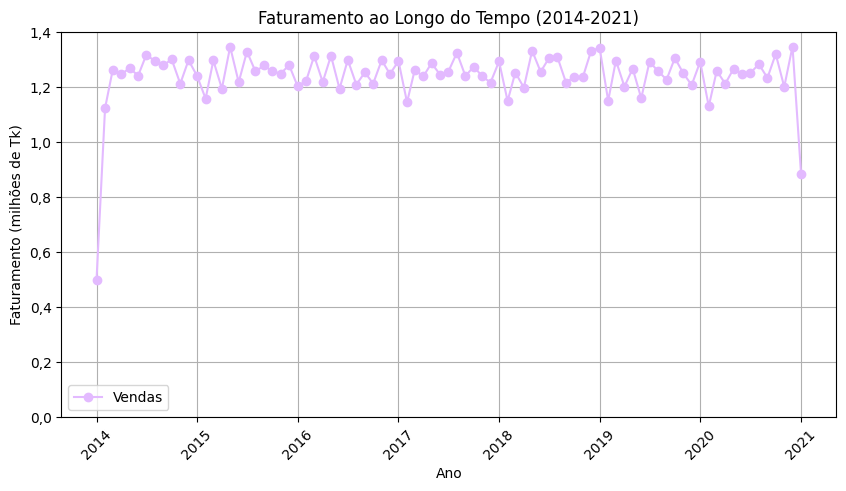

In [30]:
# Cria o gráfico de linha.
plt.figure(figsize=(10, 5))
plt.plot(dfsoma_ano['month_year'], dfsoma_ano['total_price'] / 1_000_000, marker='o', linestyle='-', color="#E3BAFF", label='Vendas')

# Personaliza o gráfico.
plt.xlabel('Ano')
plt.ylabel("Faturamento (milhões de Tk)")
plt.title('Faturamento ao Longo do Tempo (2014-2021)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# Ajusta o formato do eixo Y para exibir os valores no formato brasileiro.
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.1f}".replace(",", "X").replace(".", ",").replace("X", ".")))

# Ajusta os limites dos eixos.
plt.gca().set_ylim(0, 1.4)  

# Mostra o gráfico.
plt.show()

O gráfico em questão traz a visão mensal e anual para todo o período de coleta dos dados (2014 - 2021). O principal aspecto a se destacar é o faturamento referente aos meses de janeiro de 2014 e 2021 que são excepcionalmente baixos. Seria de grande valia compreender os motivadores para um valor tão inferior à maioria dos dados, principalmente, pensando em falhas ou acontecimentos extremos das mais diversas naturezas, com o objetivo de mitigá-los e preveni-los. 

Passando pela dinâmica de faturamento dos demais meses, nota-se um perfil bastante oscilatório, mas que se atém sempre a uma faixa bem definida de valores. Um olhar mais cuidadoso, como será visto a seguir, para os meses de baixa pode ser útil na concepção de campanhas e outras medidas que alavanquem as vendas destes períodos. 

Vale reforçar que em 2021, foram coletados dados apenas em janeiro.